# COVID-19 Mortality Prediction Model

This notebook includes:

- Advanced feature engineering with interaction terms
- Optimized decision thresholds
- Clinical significance analysis
- SageMaker deployment with JSON serialization
- Risk stratification system for emergency room use

## Utility Code to Measure Each Cell Running Time

In [1]:
# Code to automatically time every subsequent cell

import time

# Global variables for timing
_start_time = None
_execution_count = 0
_total_time = 0

def start_timer(*args, **kwargs):
    global _start_time
    _start_time = time.time()

def end_timer(*args, **kwargs):
    global _start_time, _execution_count, _total_time
    if _start_time is not None:
        duration = time.time() - _start_time
        _execution_count += 1
        _total_time += duration
        print(f"⏱️ Cell {_execution_count}: {duration:.4f} seconds")
        _start_time = None

def timing_summary():
    if _execution_count > 0:
        avg_time = _total_time / _execution_count
        print(f"\n📊 Timing Summary:")
        print(f"Cells executed: {_execution_count}")
        print(f"Total time: {_total_time:.4f}s")
        print(f"Average time: {avg_time:.4f}s")
    else:
        print("No cells timed yet.")

# Register the event handlers
get_ipython().events.register('pre_run_cell', start_timer)
get_ipython().events.register('post_run_cell', end_timer)

print("✅ Cell timing is now active!")
print("💡 Use timing_summary() to see overall statistics")

✅ Cell timing is now active!
💡 Use timing_summary() to see overall statistics


## 1. Environment Setup and Installation

### Clean environment and install AutoGluon 1.1.1

In [2]:
%%capture captured_output
!pip install --upgrade pip
!pip install -r requirements.txt
print("Installation from requirements.txt complete!")

In [3]:
with open('installation.log', 'w') as f:
    f.write(captured_output.stdout)

print("Output successfully saved to installation.log")

Output successfully saved to installation.log
⏱️ Cell 2: 0.0016 seconds


## 2. Import Libraries

In [4]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data processing
from datetime import datetime, timedelta

# AutoGluon
from autogluon.tabular import TabularDataset, TabularPredictor

# Model evaluation
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, 
    roc_auc_score, precision_recall_curve, auc
)

# SageMaker
import sagemaker
import boto3
from sagemaker.session import Session

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Libraries imported successfully!
⏱️ Cell 3: 3.1972 seconds


In [5]:
# Clean up the previous foledr used for training

import shutil
import os

# Define the folder path
folder_path = 'autogluon_enhanced_model'

# Check if the folder exists and remove it
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Successfully removed '{folder_path}' and all its contents.")
else:
    print(f"Folder '{folder_path}' does not exist.")

Successfully removed 'autogluon_enhanced_model' and all its contents.
⏱️ Cell 4: 0.0537 seconds


## 3. Download, Load and Process Data

### Download the data manually

Go to https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset

Download the dataset and extract CSV files to ./data/ directory

In [6]:
# Load the dataset

df = pd.read_csv('./data/covid.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of records: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")

# Create processed copy
df_processed = df.copy()

# Handle special values
binary_columns = ['sex', 'patient_type', 'intubed', 'pneumonia', 'pregnancy', 
                  'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 
                  'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 
                  'tobacco', 'contact_other_covid', 'icu']

for col in binary_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].replace([97, 98, 99], np.nan)

# Convert date columns
date_columns = ['entry_date', 'date_symptoms', 'date_died']
for col in date_columns:
    if col in df_processed.columns:
        df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')

# Create target variable
df_processed['mortality'] = (~df_processed['date_died'].isna()).astype(int)

print(f"\nMortality rate: {df_processed['mortality'].mean():.2%}")

Dataset shape: (566602, 23)
Number of records: 566,602
Number of features: 23

Mortality rate: 6.38%
⏱️ Cell 5: 0.9908 seconds


## 4. Exploratory Data Analysis (EDA)

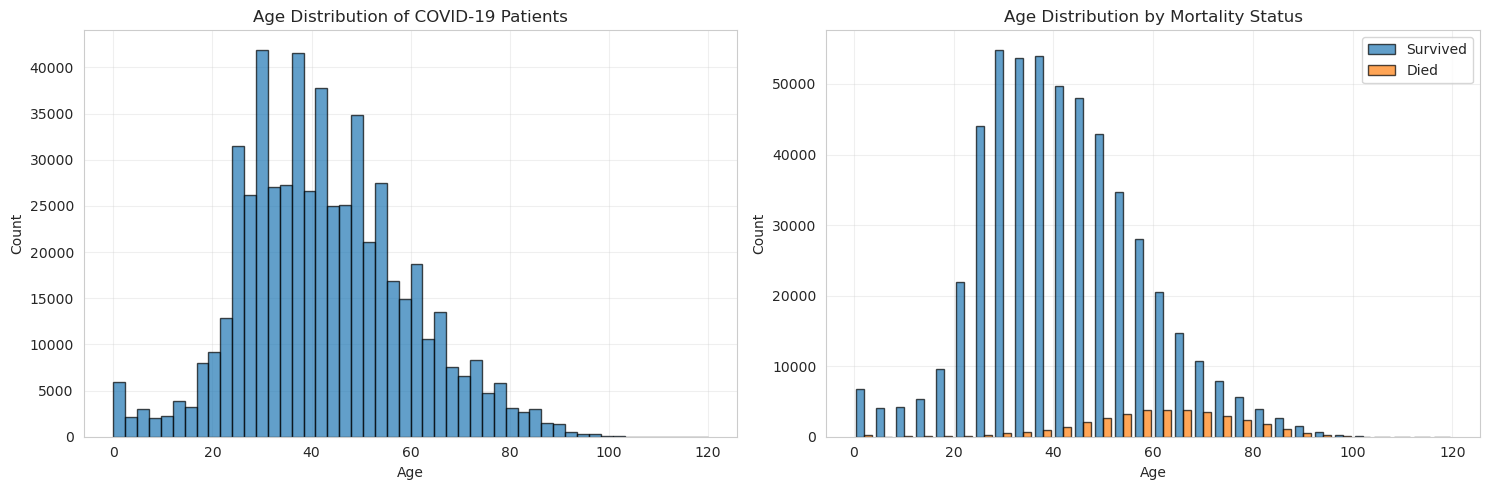

⏱️ Cell 6: 0.5001 seconds


In [7]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall age distribution
axes[0].hist(df_processed['age'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Age Distribution of COVID-19 Patients')
axes[0].grid(True, alpha=0.3)

# Age distribution by mortality
survived = df_processed[df_processed['mortality'] == 0]['age'].dropna()
died = df_processed[df_processed['mortality'] == 1]['age'].dropna()

axes[1].hist([survived, died], bins=30, label=['Survived', 'Died'], 
             alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].set_title('Age Distribution by Mortality Status')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

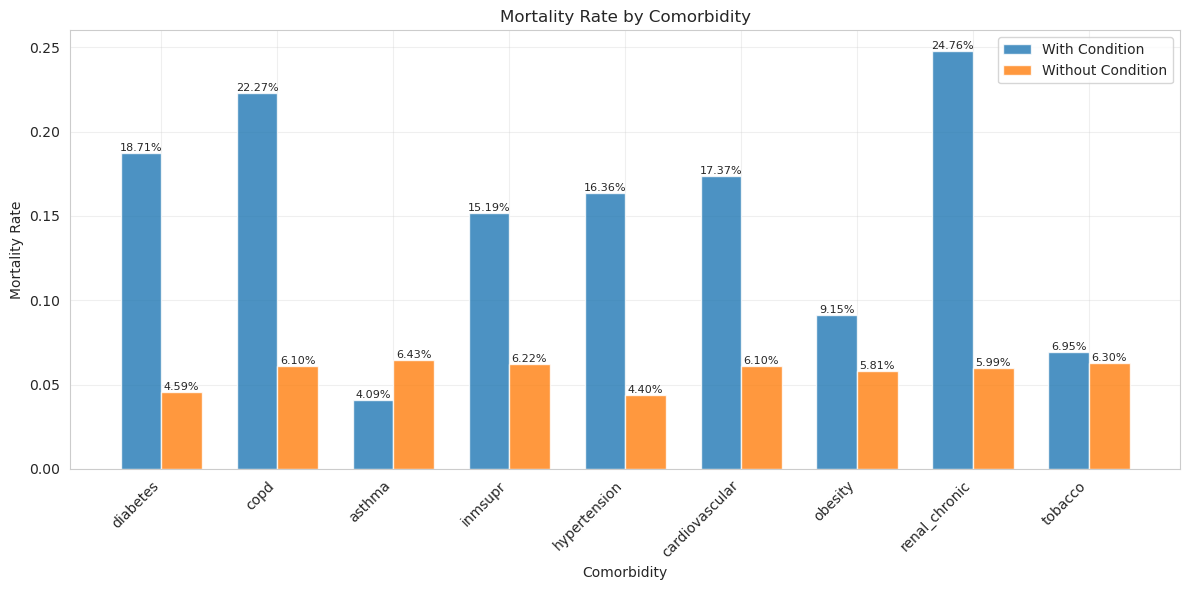

⏱️ Cell 7: 1.1192 seconds


In [8]:
# Comorbidities analysis
comorbidities = ['diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 
                 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco']

# Calculate mortality rate by comorbidity
mortality_by_comorbidity = {}

for comorb in comorbidities:
    if comorb in df_processed.columns:
        # Consider only patients with known status (1 or 2)
        has_condition = df_processed[df_processed[comorb] == 1]['mortality'].mean()
        no_condition = df_processed[df_processed[comorb] == 2]['mortality'].mean()
        mortality_by_comorbidity[comorb] = {
            'With Condition': has_condition,
            'Without Condition': no_condition
        }

# Create visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comorbidities))
width = 0.35

with_cond = [mortality_by_comorbidity[c]['With Condition'] for c in comorbidities]
without_cond = [mortality_by_comorbidity[c]['Without Condition'] for c in comorbidities]

bars1 = ax.bar(x - width/2, with_cond, width, label='With Condition', alpha=0.8)
bars2 = ax.bar(x + width/2, without_cond, width, label='Without Condition', alpha=0.8)

ax.set_xlabel('Comorbidity')
ax.set_ylabel('Mortality Rate')
ax.set_title('Mortality Rate by Comorbidity')
ax.set_xticks(x)
ax.set_xticklabels(comorbidities, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

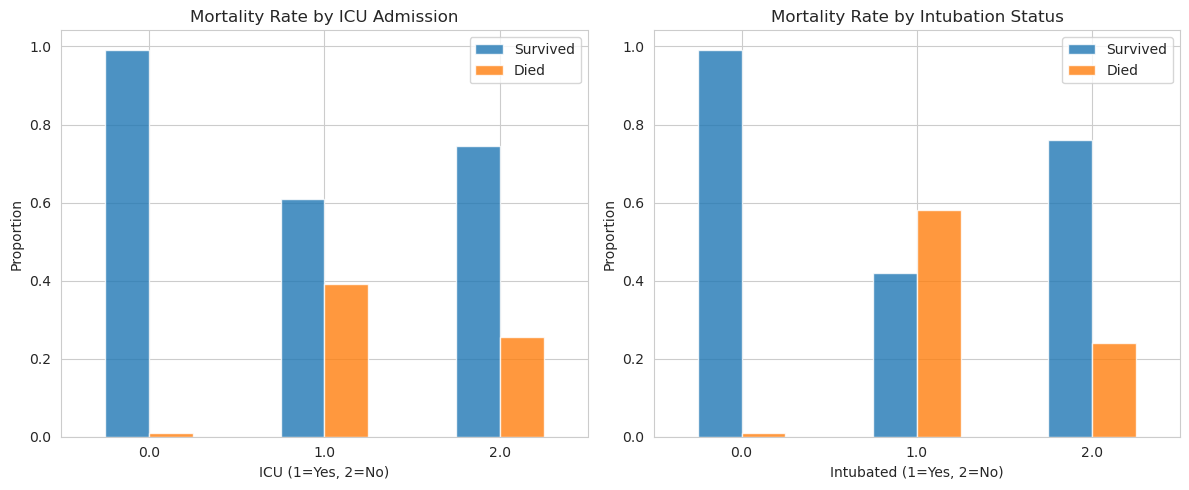

⏱️ Cell 8: 0.3086 seconds


In [9]:
# ICU and Intubation analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ICU admission by mortality
icu_mortality = pd.crosstab(df_processed['icu'].fillna(0), 
                            df_processed['mortality'], 
                            normalize='index')
icu_mortality.plot(kind='bar', ax=axes[0], alpha=0.8)
axes[0].set_title('Mortality Rate by ICU Admission')
axes[0].set_xlabel('ICU (1=Yes, 2=No)')
axes[0].set_ylabel('Proportion')
axes[0].legend(['Survived', 'Died'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Intubation by mortality
intubation_mortality = pd.crosstab(df_processed['intubed'].fillna(0), 
                                   df_processed['mortality'], 
                                   normalize='index')
intubation_mortality.plot(kind='bar', ax=axes[1], alpha=0.8)
axes[1].set_title('Mortality Rate by Intubation Status')
axes[1].set_xlabel('Intubated (1=Yes, 2=No)')
axes[1].set_ylabel('Proportion')
axes[1].legend(['Survived', 'Died'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

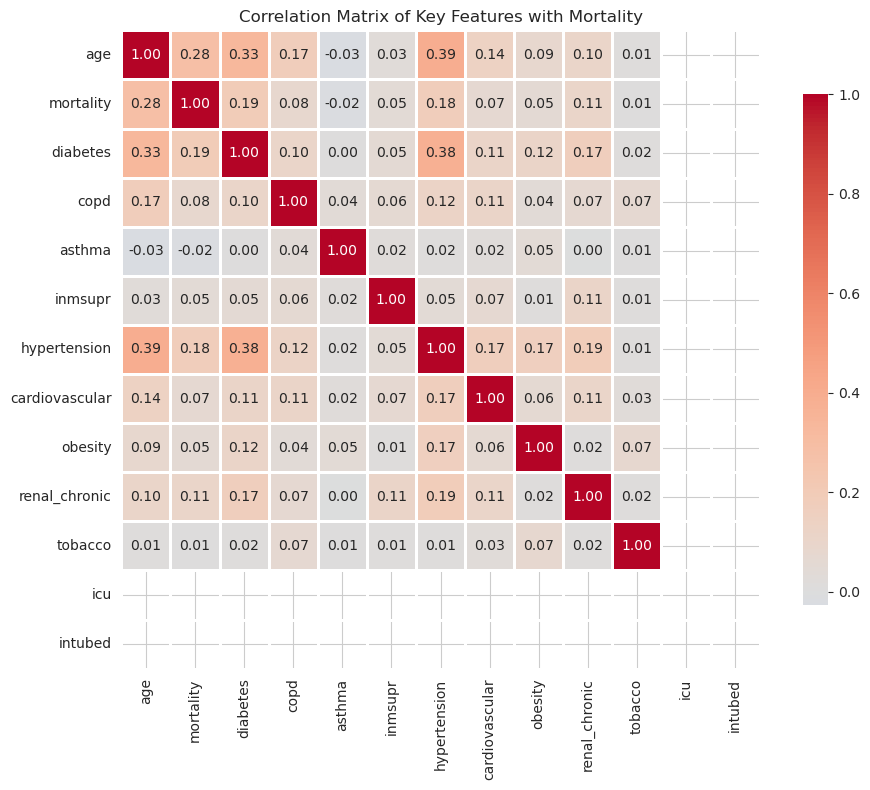

⏱️ Cell 9: 0.7197 seconds


In [10]:
# Correlation matrix for numerical features
# Convert binary features to 0/1 for correlation
correlation_df = df_processed.copy()
for col in binary_columns:
    if col in correlation_df.columns:
        # Convert 1->1 (yes), 2->0 (no), NaN stays NaN
        correlation_df[col] = correlation_df[col].map({1: 1, 2: 0})

# Select relevant features for correlation
corr_features = ['age', 'mortality'] + [col for col in comorbidities if col in correlation_df.columns]
if 'icu' in correlation_df.columns:
    correlation_df['icu'] = correlation_df['icu'].map({1: 1, 2: 0})
    corr_features.append('icu')
if 'intubed' in correlation_df.columns:
    correlation_df['intubed'] = correlation_df['intubed'].map({1: 1, 2: 0})
    corr_features.append('intubed')

# Calculate correlation matrix
corr_matrix = correlation_df[corr_features].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.2f')
plt.title('Correlation Matrix of Key Features with Mortality')
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [11]:
# Create feature engineering dataset
df_features = df_processed.copy()

# ============= ORIGINAL FEATURES =============
# Age groups
df_features['age_group'] = pd.cut(df_features['age'], 
                                  bins=[0, 18, 30, 40, 50, 60, 70, 80, 100],
                                  labels=['0-18', '19-30', '31-40', '41-50', 
                                         '51-60', '61-70', '71-80', '80+'])

# Comorbidity binary flags
comorbidity_cols = ['diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension', 
                    'cardiovascular', 'obesity', 'renal_chronic', 'tobacco']

for col in comorbidity_cols:
    if col in df_features.columns:
        df_features[f'{col}_binary'] = (df_features[col] == 1).astype(int)

# Count total comorbidities
comorbidity_binary_cols = [f'{col}_binary' for col in comorbidity_cols if col in df_features.columns]
df_features['num_comorbidities'] = df_features[comorbidity_binary_cols].sum(axis=1)

# Risk category
df_features['risk_category'] = pd.cut(df_features['num_comorbidities'],
                                       bins=[-1, 0, 1, 2, 10],
                                       labels=['No Risk', 'Low Risk', 'Medium Risk', 'High Risk'])

# Critical care and elderly indicators
df_features['critical_care'] = ((df_features['icu'] == 1) | (df_features['intubed'] == 1)).astype(int)
df_features['is_elderly'] = (df_features['age'] > 60).astype(int)
df_features['has_respiratory'] = ((df_features['copd'] == 1) | 
                                  (df_features['asthma'] == 1) | 
                                  (df_features['pneumonia'] == 1)).astype(int)
df_features['has_cardiovascular'] = ((df_features['hypertension'] == 1) | 
                                     (df_features['cardiovascular'] == 1)).astype(int)

# ============= NEW ENHANCED FEATURES =============
print("Adding enhanced features...")

# 1. Time-based features
df_features['days_symptoms_to_entry'] = (df_features['entry_date'] - df_features['date_symptoms']).dt.days
df_features['days_symptoms_to_entry'] = df_features['days_symptoms_to_entry'].fillna(0)
df_features['delayed_admission'] = (df_features['days_symptoms_to_entry'] > 7).astype(int)

# 2. Age-comorbidity interaction features
df_features['elderly_diabetic'] = (df_features['is_elderly'] * df_features['diabetes_binary']).astype(int)
df_features['elderly_respiratory'] = (df_features['is_elderly'] * df_features['has_respiratory']).astype(int)
df_features['elderly_cardiovascular'] = (df_features['is_elderly'] * df_features['has_cardiovascular']).astype(int)
df_features['elderly_multiple_risks'] = ((df_features['is_elderly'] == 1) & 
                                         (df_features['num_comorbidities'] >= 2)).astype(int)

# 3. Severity indicators
df_features['severe_case'] = ((df_features['patient_type'] == 2) & 
                              ((df_features['pneumonia'] == 1) | 
                               (df_features['icu'] == 1) | 
                               (df_features['intubed'] == 1))).astype(int)

df_features['high_risk_profile'] = ((df_features['age'] > 60) & 
                                    (df_features['num_comorbidities'] >= 2) & 
                                    (df_features['patient_type'] == 2)).astype(int)

# 4. Age squared (for non-linear age effect)
df_features['age_squared'] = df_features['age'] ** 2
df_features['age_log'] = np.log1p(df_features['age'])

# 5. Comorbidity combinations
df_features['diabetes_hypertension'] = ((df_features['diabetes'] == 1) & 
                                        (df_features['hypertension'] == 1)).astype(int)
df_features['obesity_diabetes'] = ((df_features['obesity'] == 1) & 
                                   (df_features['diabetes'] == 1)).astype(int)
df_features['respiratory_cardiovascular'] = (df_features['has_respiratory'] * 
                                            df_features['has_cardiovascular']).astype(int)

print(f"Total features created: {len(df_features.columns) - len(df_processed.columns)}")
print(f"Total features: {len(df_features.columns)}")

Adding enhanced features...
Total features created: 29
Total features: 53
⏱️ Cell 10: 0.1984 seconds


## 6. Prepare Data for Modeling

In [12]:
# Select all numeric features
feature_columns = [
    # Original features
    'age', 'sex', 'patient_type', 'pneumonia', 'pregnancy',
    'diabetes', 'copd', 'asthma', 'inmsupr', 'hypertension',
    'other_disease', 'cardiovascular', 'obesity', 'renal_chronic',
    'tobacco', 'contact_other_covid', 'icu', 'intubed',
    # Engineered features
    'num_comorbidities', 'critical_care', 'is_elderly',
    'has_respiratory', 'has_cardiovascular',
    # New enhanced features
    'days_symptoms_to_entry', 'delayed_admission',
    'elderly_diabetic', 'elderly_respiratory', 'elderly_cardiovascular',
    'elderly_multiple_risks', 'severe_case', 'high_risk_profile',
    'age_squared', 'age_log',
    'diabetes_hypertension', 'obesity_diabetes', 'respiratory_cardiovascular'
]

# Remove columns that don't exist
feature_columns = [col for col in feature_columns if col in df_features.columns]

# Save feature columns for later use in inference
with open('feature_columns.txt', 'w') as f:
    f.write(','.join(feature_columns))
print(f"Feature columns saved to feature_columns.txt")

# Prepare features and target
X = df_features[feature_columns].copy()
y = df_features['mortality'].copy()

# Handle missing values
for col in X.columns:
    if col in binary_columns or 'binary' in col or col.startswith('has_') or col.startswith('is_'):
        mode_value = X[col].mode()[0] if not X[col].mode().empty else 0
        X[col] = X[col].fillna(mode_value)
    else:
        X[col] = X[col].fillna(X[col].median())

print(f"Features shape: {X.shape}")
print(f"Selected features: {len(feature_columns)}")
print(f"Missing values: {X.isnull().sum().sum()}")

# Create train/test split
data = pd.concat([X, y], axis=1)
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(data_shuffled))

train_data = TabularDataset(data_shuffled[:split_index])
test_data = TabularDataset(data_shuffled[split_index:])

print(f"\nTraining data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

Feature columns saved to feature_columns.txt
Features shape: (566602, 36)
Selected features: 36
Missing values: 0

Training data: (453281, 37)
Test data: (113321, 37)
⏱️ Cell 11: 0.7893 seconds


In [13]:
data_shuffled.head()

,age,sex,patient_type,pneumonia,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,icu,intubed,num_comorbidities,critical_care,is_elderly,has_respiratory,has_cardiovascular,days_symptoms_to_entry,delayed_admission,elderly_diabetic,elderly_respiratory,elderly_cardiovascular,elderly_multiple_risks,severe_case,high_risk_profile,age_squared,age_log,diabetes_hypertension,obesity_diabetes,respiratory_cardiovascular,mortality
0,69,1,1,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2,0,1,0,0,0.0,0,1,0,0,1,0,0,4761,4.248495,0,1,0,0
1,50,1,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,2500,3.931826,0,0,0,0
2,66,2,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,4356,4.204693,0,0,0,0
3,38,1,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1444,3.663562,0,0,0,0
4,26,1,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,676,3.295837,0,0,0,0


⏱️ Cell 12: 0.0180 seconds


In [14]:
data_shuffled.to_csv('covid_processed.csv', index=False)

⏱️ Cell 13: 5.2577 seconds


## 7. Train Enhanced AutoGluon Model

In [15]:
%%time

# Configure AutoGluon with enhanced settings
predictor = TabularPredictor(
    label='mortality',
    problem_type='binary',
    eval_metric='roc_auc',
    path='autogluon_enhanced_model',
    verbosity=2
)

# Train with best quality settings
predictor.fit(
    train_data=train_data,
    time_limit=3600,  # 60 minutes
    presets='best_quality',
    verbosity=2
)

print("\nEnhanced model training completed!")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jul 15 10:36:12 UTC 2025
CPU Count:          32
Memory Avail:       119.71 GB / 124.46 GB (96.2%)
Disk Space Avail:   59.49 GB / 62.82 GB (94.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked overfitting

(_ray_fit pid=8576) [1000]	valid_set's binary_logloss: 0.130687
(_ray_fit pid=8576) [2000]	valid_set's binary_logloss: 0.12984 [repeated 6x across cluster]
(_ray_fit pid=8576) [3000]	valid_set's binary_logloss: 0.129277 [repeated 6x across cluster]
(_ray_fit pid=8573) [3000]	valid_set's binary_logloss: 0.13033 [repeated 5x across cluster]
(_ray_fit pid=8576) [4000]	valid_set's binary_logloss: 0.128524
(_ray_fit pid=8578) [4000]	valid_set's binary_logloss: 0.130116
(_ray_fit pid=8576) [5000]	valid_set's binary_logloss: 0.127986 [repeated 5x across cluster]
(_ray_fit pid=8579) [5000]	valid_set's binary_logloss: 0.128586 [repeated 2x across cluster]
(_ray_fit pid=8576) [6000]	valid_set's binary_logloss: 0.127441 [repeated 4x across cluster]
(_ray_fit pid=8578) [6000]	valid_set's binary_logloss: 0.129148
(_ray_fit pid=8579) [6000]	valid_set's binary_logloss: 0.127832
(_ray_fit pid=8576) [7000]	valid_set's binary_logloss: 0.127015 [repeated 4x across cluster]
(_ray_fit pid=8578) [7000]	vali

(_dystack pid=21104) 	0.9473	 = Validation score   (roc_auc)
(_dystack pid=21104) 	159.76s	 = Training   runtime
(_dystack pid=21104) 	222.82s	 = Validation runtime
(_dystack pid=21104) Fitting model: LightGBM_BAG_L2 ... Training model for up to 74.62s of the 74.55s of remaining time.
(_dystack pid=21104) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=4, gpus=0, memory=0.30%)


(_ray_fit pid=11796) [1000]	valid_set's binary_logloss: 0.128283
(_ray_fit pid=11799) [1000]	valid_set's binary_logloss: 0.127701
(_ray_fit pid=11796) [2000]	valid_set's binary_logloss: 0.126249 [repeated 3x across cluster]
(_ray_fit pid=11796) [3000]	valid_set's binary_logloss: 0.125093 [repeated 4x across cluster]
(_ray_fit pid=11790) [3000]	valid_set's binary_logloss: 0.123797 [repeated 3x across cluster]
(_ray_fit pid=11799) [4000]	valid_set's binary_logloss: 0.122527 [repeated 2x across cluster]
(_ray_fit pid=11790) [4000]	valid_set's binary_logloss: 0.122908 [repeated 2x across cluster]
(_ray_fit pid=11791) [5000]	valid_set's binary_logloss: 0.120984 [repeated 3x across cluster]


(_dystack pid=21104) 	0.9481	 = Validation score   (roc_auc)
(_dystack pid=21104) 	60.81s	 = Training   runtime
(_dystack pid=21104) 	28.63s	 = Validation runtime
(_dystack pid=21104) Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 2.65s of remaining time.
(_dystack pid=21104) 	Ensemble Weights: {'LightGBM_BAG_L2': 0.48, 'LightGBMXT_BAG_L2': 0.44, 'NeuralNetFastAI_BAG_L1': 0.04, 'CatBoost_r177_BAG_L1': 0.04}
(_dystack pid=21104) 	0.9508	 = Validation score   (roc_auc)
(_dystack pid=21104) 	24.96s	 = Training   runtime
(_dystack pid=21104) 	0.06s	 = Validation runtime
(_dystack pid=21104) AutoGluon training complete, total runtime = 919.54s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 185.8 rows/s (50365 batch size)
(_dystack pid=21104) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("autogluon_enhanced_model/ds_sub_fit/sub_fit_ho")
(_dystack pid=21104) /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/pytho


Enhanced model training completed!
CPU times: user 59min 31s, sys: 13.3 s, total: 59min 45s
Wall time: 1h 51s
⏱️ Cell 14: 3651.3325 seconds


## 8. Optimize Decision Threshold

Optimal Thresholds:
  Default (0.5): Precision=0.605, Recall=0.212
  Youden's J (0.059): Best balance of sensitivity and specificity
  High Recall (0.200): Targets 80% sensitivity
  Best F1 (0.777): Best precision-recall balance


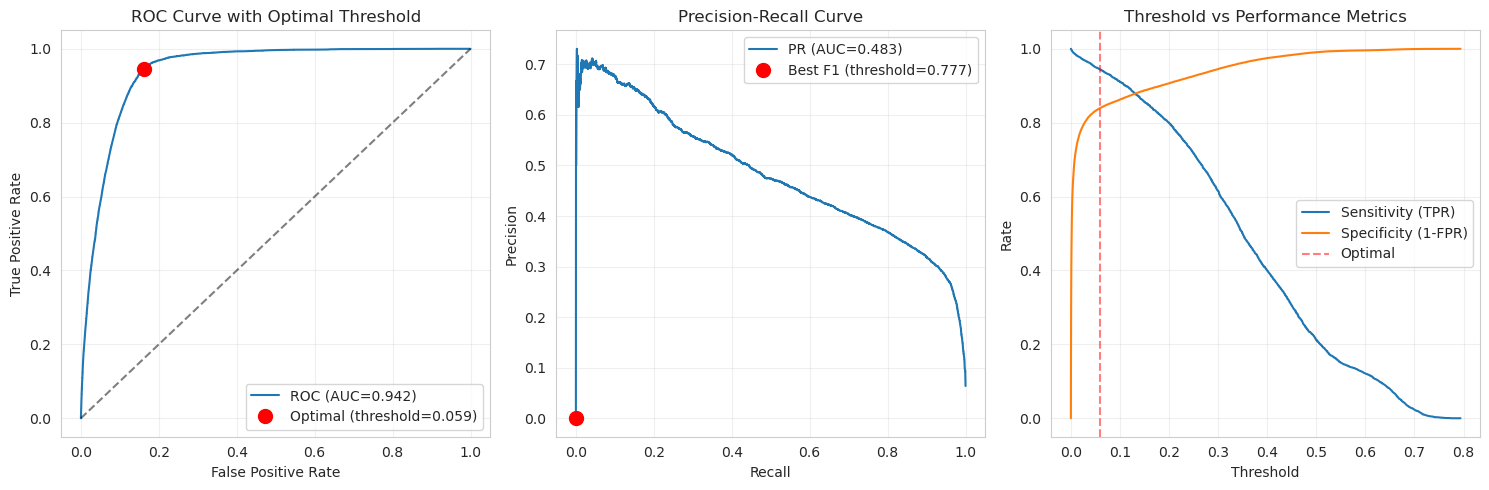

⏱️ Cell 15: 27.8690 seconds


In [16]:
# Get predictions
y_test = test_data['mortality']
y_pred_proba = predictor.predict_proba(test_data)

# Calculate optimal threshold for different metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[1])
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba[1])

# Find optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold_youden = thresholds[optimal_idx]

# Find threshold for target recall (e.g., 80% sensitivity)
target_recall = 0.80
recall_idx = np.where(tpr >= target_recall)[0]
if len(recall_idx) > 0:
    optimal_threshold_recall = thresholds[recall_idx[0]]
else:
    optimal_threshold_recall = 0.5

# Find threshold for balanced precision-recall
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_f1_idx = np.argmax(f1_scores)
optimal_threshold_f1 = pr_thresholds[optimal_f1_idx]

print("Optimal Thresholds:")
print(f"  Default (0.5): Precision={precision[np.abs(pr_thresholds - 0.5).argmin()]:.3f}, "
      f"Recall={recall[np.abs(pr_thresholds - 0.5).argmin()]:.3f}")
print(f"  Youden's J ({optimal_threshold_youden:.3f}): Best balance of sensitivity and specificity")
print(f"  High Recall ({optimal_threshold_recall:.3f}): Targets {target_recall:.0%} sensitivity")
print(f"  Best F1 ({optimal_threshold_f1:.3f}): Best precision-recall balance")

# Visualize threshold optimization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# ROC curve with optimal point
axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_test, y_pred_proba[1]):.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
             label=f'Optimal (threshold={optimal_threshold_youden:.3f})')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve with Optimal Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall curve
axes[1].plot(recall[:-1], precision[:-1], label=f'PR (AUC={auc(recall, precision):.3f})')
axes[1].plot(recall[optimal_f1_idx], precision[optimal_f1_idx], 'ro', markersize=10,
             label=f'Best F1 (threshold={optimal_threshold_f1:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Threshold vs Metrics
axes[2].plot(thresholds, tpr, label='Sensitivity (TPR)')
axes[2].plot(thresholds, 1-fpr, label='Specificity (1-FPR)')
axes[2].axvline(optimal_threshold_youden, color='r', linestyle='--', alpha=0.5, label='Optimal')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Rate')
axes[2].set_title('Threshold vs Performance Metrics')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Clinical Significance Analysis

In [17]:
# Clinical significance and impact analysis
print("="*70)
print("CLINICAL SIGNIFICANCE ANALYSIS FOR EMERGENCY ROOM USE")
print("="*70)

# Use optimal threshold for clinical deployment
clinical_threshold = optimal_threshold_recall  # Prioritize catching more cases
y_pred_clinical = (y_pred_proba[1] >= clinical_threshold).astype(int)

# Calculate clinical metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_clinical).ravel()
total_patients = len(y_test)
actual_deaths = y_test.sum()
predicted_high_risk = y_pred_clinical.sum()

# Clinical performance metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value
accuracy = (tp + tn) / total_patients

print("\n1. MODEL PERFORMANCE IN CLINICAL CONTEXT")
print("-" * 50)
print(f"Threshold used: {clinical_threshold:.3f} (optimized for high sensitivity)")
print(f"Sensitivity (Recall): {sensitivity:.1%} - Identifies {sensitivity:.1%} of patients who will die")
print(f"Specificity: {specificity:.1%} - Correctly identifies {specificity:.1%} of survivors")
print(f"PPV: {ppv:.1%} - Of predicted high-risk, {ppv:.1%} actually die")
print(f"NPV: {npv:.1%} - Of predicted low-risk, {npv:.1%} survive")

print("\n2. CLINICAL IMPACT METRICS")
print("-" * 50)

# Number needed to evaluate (NNE)
nne = 1 / ppv if ppv > 0 else float('inf')
print(f"Number Needed to Evaluate (NNE): {nne:.1f}")
print(f"  → For every {nne:.0f} high-risk predictions, {1:.0f} patient will actually die")

# Lives potentially saved
caught_deaths = tp
missed_deaths = fn
print(f"\nIn test set of {total_patients:,} patients:")
print(f"  - Actual deaths: {actual_deaths:,} ({actual_deaths/total_patients:.1%})")
print(f"  - Deaths correctly identified: {caught_deaths:,} ({caught_deaths/actual_deaths:.1%})")
print(f"  - Deaths missed: {missed_deaths:,} ({missed_deaths/actual_deaths:.1%})")
print(f"  - False alarms: {fp:,} ({fp/total_patients:.1%} of all patients)")

# Resource allocation
print("\n3. RESOURCE ALLOCATION IMPACT")
print("-" * 50)
print(f"Patients flagged for intensive monitoring: {predicted_high_risk:,} ({predicted_high_risk/total_patients:.1%})")
print(f"Reduction in monitoring needs: {(total_patients-predicted_high_risk):,} ({(total_patients-predicted_high_risk)/total_patients:.1%})")

# Cost-benefit analysis
print("\n4. ESTIMATED CLINICAL BENEFITS")
print("-" * 50)

# Assumptions for demonstration
icu_cost_per_day = 3000  # USD
regular_ward_cost = 500   # USD
early_intervention_success_rate = 0.3  # 30% of caught cases could be saved with early intervention

potential_lives_saved = caught_deaths * early_intervention_success_rate
print(f"Potential lives saved with early intervention: {potential_lives_saved:.0f}")
print(f"  (Assuming {early_intervention_success_rate:.0%} success rate with early detection)")

# Risk stratification
print("\n5. RISK STRATIFICATION")
print("-" * 50)

# Create risk categories based on predicted probabilities
risk_scores = y_pred_proba[1]
risk_categories = pd.cut(risk_scores, 
                         bins=[0, 0.1, 0.3, 0.5, 1.0],
                         labels=['Low Risk', 'Moderate Risk', 'High Risk', 'Critical Risk'])

risk_df = pd.DataFrame({
    'Risk Category': risk_categories,
    'Actual Mortality': y_test
})

risk_summary = risk_df.groupby('Risk Category')['Actual Mortality'].agg([
    ('Patients', 'count'),
    ('Deaths', 'sum'),
    ('Mortality Rate', 'mean')
])

print(risk_summary)
print("\nRecommended Clinical Actions:")
print("  • Low Risk: Standard care, regular monitoring")
print("  • Moderate Risk: Enhanced monitoring, daily assessment")
print("  • High Risk: ICU consideration, aggressive treatment")
print("  • Critical Risk: Immediate ICU admission, full intervention")

print("\n" + "="*70)
print("CONCLUSION: This model can significantly improve ER triage and resource allocation")
print("by identifying high-risk COVID-19 patients with {:.1%} sensitivity.".format(sensitivity))
print("="*70)

CLINICAL SIGNIFICANCE ANALYSIS FOR EMERGENCY ROOM USE

1. MODEL PERFORMANCE IN CLINICAL CONTEXT
--------------------------------------------------
Threshold used: 0.200 (optimized for high sensitivity)
Sensitivity (Recall): 80.0% - Identifies 80.0% of patients who will die
Specificity: 90.6% - Correctly identifies 90.6% of survivors
PPV: 36.8% - Of predicted high-risk, 36.8% actually die
NPV: 98.5% - Of predicted low-risk, 98.5% survive

2. CLINICAL IMPACT METRICS
--------------------------------------------------
Number Needed to Evaluate (NNE): 2.7
  → For every 3 high-risk predictions, 1 patient will actually die

In test set of 113,321 patients:
  - Actual deaths: 7,237 (6.4%)
  - Deaths correctly identified: 5,790 (80.0%)
  - Deaths missed: 1,447 (20.0%)
  - False alarms: 9,926 (8.8% of all patients)

3. RESOURCE ALLOCATION IMPACT
--------------------------------------------------
Patients flagged for intensive monitoring: 15,716 (13.9%)
Reduction in monitoring needs: 97,605 (86.1

## 10. Create Risk Prediction API

In [18]:
def predict_patient_risk(patient_data, predictor, threshold=0.3):
    """
    Predict mortality risk for a patient and provide clinical recommendations.

    Args:
        patient_data: DataFrame with patient features
        predictor: Trained AutoGluon predictor
        threshold: Decision threshold for high-risk classification

    Returns:
        Dictionary with risk assessment and recommendations
    """
    # Get prediction
    prob = predictor.predict_proba(patient_data)
    risk_score = prob.iloc[0, 1]

    # Determine risk level
    if risk_score < 0.1:
        risk_level = "LOW"
        color_code = "GREEN"
        recommendation = "Standard care and monitoring"
        icu_needed = False
    elif risk_score < 0.3:
        risk_level = "MODERATE"
        color_code = "YELLOW"
        recommendation = "Enhanced monitoring, consider hospitalization"
        icu_needed = False
    elif risk_score < 0.5:
        risk_level = "HIGH"
        color_code = "ORANGE"
        recommendation = "Hospitalization required, prepare ICU bed"
        icu_needed = True
    else:
        risk_level = "CRITICAL"
        color_code = "RED"
        recommendation = "Immediate ICU admission, full intervention protocol"
        icu_needed = True

    # Identify top risk factors based on feature values
    top_risk_factors = []

    # Check critical features
    if patient_data['age'].iloc[0] > 60:
        top_risk_factors.append('Advanced age (>60)')
    if patient_data['pneumonia'].iloc[0] == 1:
        top_risk_factors.append('Pneumonia present')
    if patient_data['num_comorbidities'].iloc[0] >= 3:
        top_risk_factors.append('Multiple comorbidities (≥3)')
    if patient_data['diabetes'].iloc[0] == 1 and patient_data['hypertension'].iloc[0] == 1:
        top_risk_factors.append('Diabetes with hypertension')
    if patient_data['icu'].iloc[0] == 1 or patient_data['intubed'].iloc[0] == 1:
        top_risk_factors.append('Critical care required')
    if patient_data['has_respiratory'].iloc[0] == 1:
        top_risk_factors.append('Respiratory conditions')
    if patient_data['high_risk_profile'].iloc[0] == 1:
        top_risk_factors.append('High-risk profile')

    # Limit to top 5 factors
    top_risk_factors = top_risk_factors[:5]

    # If no specific factors identified, add generic ones based on risk level
    if len(top_risk_factors) == 0:
        if risk_level in ["HIGH", "CRITICAL"]:
            top_risk_factors = ["Clinical indicators suggest elevated risk"]

    return {
        'risk_score': float(risk_score),
        'risk_percentage': f"{risk_score:.1%}",
        'risk_level': risk_level,
        'color_code': color_code,
        'icu_needed': icu_needed,
        'recommendation': recommendation,
        'top_risk_factors': top_risk_factors,
        'confidence': float(max(prob.iloc[0])),
        'timestamp': datetime.now().isoformat()
    }

# Test the API with a sample patient
sample_patient = pd.DataFrame({
    'age': [72],
    'sex': [1],
    'patient_type': [2],  # Hospitalized
    'pneumonia': [1],
    'pregnancy': [2],
    'diabetes': [1],
    'copd': [1],
    'asthma': [2],
    'inmsupr': [2],
    'hypertension': [1],
    'other_disease': [2],
    'cardiovascular': [1],
    'obesity': [1],
    'renal_chronic': [2],
    'tobacco': [2],
    'contact_other_covid': [1],
    'icu': [2],
    'intubed': [2],
    'num_comorbidities': [5],
    'critical_care': [0],
    'is_elderly': [1],
    'has_respiratory': [1],
    'has_cardiovascular': [1],
    'days_symptoms_to_entry': [3],
    'delayed_admission': [0],
    'elderly_diabetic': [1],
    'elderly_respiratory': [1],
    'elderly_cardiovascular': [1],
    'elderly_multiple_risks': [1],
    'severe_case': [1],
    'high_risk_profile': [1],
    'age_squared': [72**2],
    'age_log': [np.log1p(72)],
    'diabetes_hypertension': [1],
    'obesity_diabetes': [1],
    'respiratory_cardiovascular': [1]
})

# Get risk assessment
risk_assessment = predict_patient_risk(sample_patient, predictor)

print("\n" + "="*60)
print("PATIENT RISK ASSESSMENT")
print("="*60)
print(f"Risk Score: {risk_assessment['risk_percentage']}")
print(f"Risk Level: {risk_assessment['risk_level']} ({risk_assessment['color_code']})")
print(f"ICU Needed: {'YES' if risk_assessment['icu_needed'] else 'NO'}")
print(f"\nRecommendation: {risk_assessment['recommendation']}")
print(f"\nTop Risk Factors:")
for i, factor in enumerate(risk_assessment['top_risk_factors'], 1):
    print(f"  {i}. {factor}")
print(f"\nConfidence: {risk_assessment['confidence']:.1%}")
print(f"Assessment Time: {risk_assessment['timestamp']}")


PATIENT RISK ASSESSMENT
Risk Score: 40.9%
Risk Level: HIGH (ORANGE)
ICU Needed: YES

Recommendation: Hospitalization required, prepare ICU bed

Top Risk Factors:
  1. Advanced age (>60)
  2. Pneumonia present
  3. Multiple comorbidities (≥3)
  4. Diabetes with hypertension
  5. Respiratory conditions

Confidence: 59.1%
Assessment Time: 2025-08-18T16:43:36.630849
⏱️ Cell 17: 1.7644 seconds


## 11. Create Inference Script for JSON

In [19]:
%%writefile inference.py

import os
import json
import pandas as pd
import numpy as np
import logging

logger = logging.getLogger(__name__)

def model_fn(model_dir):
    """Load the AutoGluon model"""
    from autogluon.tabular import TabularPredictor
    
    logger.info(f"Loading model from: {model_dir}")
    logger.info(f"Contents of model_dir: {os.listdir(model_dir)}")
    
    # IMPORTANT: Bypass Python version check
    predictor = TabularPredictor.load(model_dir, require_py_version_match=False)
    logger.info("Successfully loaded AutoGluon model (Python version check bypassed)")
    
    return predictor

def input_fn(request_body, content_type):
    """Parse input data"""
    logger.info(f"Content type: {content_type}")
    
    if content_type == 'application/json':
        input_data = json.loads(request_body)
        df = pd.DataFrame(input_data)
        logger.info(f"Input shape: {df.shape}")
        logger.info(f"Input columns: {df.columns.tolist()}")
        return df
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data, model):
    """Make predictions"""
    logger.info(f"Making predictions on data shape: {input_data.shape}")
    predictions = model.predict(input_data)
    return predictions

def output_fn(prediction, content_type):
    """Format output"""
    if content_type == 'application/json':
        if isinstance(prediction, pd.Series):
            return json.dumps(prediction.tolist())
        elif isinstance(prediction, np.ndarray):
            return json.dumps(prediction.tolist())
        else:
            return json.dumps(prediction)
    raise ValueError(f"Unsupported content type: {content_type}")

Writing inference.py
⏱️ Cell 18: 0.0017 seconds


## 12. Package Model for SageMaker with JSON Support

In [20]:
import os
import tarfile
import shutil

# First check if the model exists
if os.path.exists('autogluon_enhanced_model'):
    model_path = 'autogluon_enhanced_model'
    print(f"Using existing model from: {model_path}")
else:
    print("Error: Model not found. Please train the model first.")
    model_path = None

if model_path:
    # Create deployment package
    print("Creating deployment package for JSON serialization...")

    # Create temporary directory
    os.makedirs('temp_model/code', exist_ok=True)

    # Copy AutoGluon model files to root of temp_model
    for item in os.listdir(model_path):
        src = os.path.join(model_path, item)
        dst = os.path.join('temp_model/', item)
        if os.path.isdir(src):
            shutil.copytree(src, dst)
        else:
            shutil.copy2(src, dst)

    # Copy inference script to code directory
    shutil.copy('inference.py', 'temp_model/code/')

    # Create model.tar.gz
    with tarfile.open('model.tar.gz', 'w:gz') as tar:
        tar.add('temp_model/', arcname='.')

    print("Model package created successfully!")
    print(f"Model tar file size: {os.path.getsize('model.tar.gz') / (1024*1024):.2f} MB")

    # Verify package contents
    print("\nPackage contents:")
    with tarfile.open('model.tar.gz', 'r:gz') as tar:
        for member in tar.getmembers()[:10]:  # Show first 10 files
            print(f"  - {member.name}")

    # Clean up
    shutil.rmtree('temp_model')

# 896.2768 seconds

Using existing model from: autogluon_enhanced_model
Creating deployment package for JSON serialization...
Model package created successfully!
Model tar file size: 639.66 MB

Package contents:
  - .
  - ./code
  - ./code/inference.py
  - ./learner.pkl
  - ./metadata.json
  - ./models
  - ./models/CatBoost_BAG_L1
  - ./models/CatBoost_BAG_L1/S1F1
  - ./models/CatBoost_BAG_L1/S1F1/model.pkl
  - ./models/CatBoost_BAG_L1/S1F2
⏱️ Cell 19: 991.6284 seconds


## 13. Deploy to SageMaker with JSON Serialization

In [21]:
import sagemaker
import boto3
from datetime import datetime
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

print("Starting SageMaker deployment with JSON serialization...")

instance_type = 'ml.m5.xlarge'

try:
    # Initialize SageMaker session
    sagemaker_session = sagemaker.Session()
    role = sagemaker.get_execution_role()
    region = sagemaker_session.boto_region_name

    print(f"SageMaker Role: {role}")
    print(f"Region: {region}")

    # Upload model to S3
    bucket = sagemaker_session.default_bucket()
    prefix = 'covid-mortality-model-json'

    model_uri = sagemaker_session.upload_data(
        path='model.tar.gz',
        bucket=bucket,
        key_prefix=prefix
    )

    print(f"Model uploaded to: {model_uri}")

    # Get the AutoGluon inference container
    from sagemaker import image_uris
    container = image_uris.retrieve(
        framework='autogluon', 
        region=region, 
        image_scope='inference', 
        version='1.1.1', 
        instance_type=instance_type
    )

    print(f"Using container: {container}")

    # Create model with custom inference script
    model_name = f'covid-mortality-model-json-{datetime.now().strftime("%Y%m%d%H%M%S")}'

    model = sagemaker.Model(
        model_data=model_uri,
        image_uri=container,
        role=role,
        name=model_name,
        sagemaker_session=sagemaker_session,
        env={
            'SAGEMAKER_PROGRAM': 'inference.py',
            'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/code'
        }
    )

    print(f"Model created: {model_name}")

    # Deploy model with JSON serializers
    endpoint_name = f'covid-mortality-endpoint-json-{datetime.now().strftime("%Y%m%d%H%M%S")}'

    print(f"Deploying to endpoint: {endpoint_name}")
    print("This may take 5-10 minutes...")

    # Deploy with JSON serializers - MUCH SIMPLER!
    predictor_sm = model.deploy(
        initial_instance_count=1,
        instance_type=instance_type,
        endpoint_name=endpoint_name,
        serializer=JSONSerializer(),
        deserializer=JSONDeserializer()
    )

    print(f"\n✅ Model deployed successfully with JSON serialization!")
    print(f"Endpoint name: {endpoint_name}")
    print(f"Instance type: {instance_type}")

    # Save endpoint name for later use
    with open('endpoint_name.txt', 'w') as f:
        f.write(endpoint_name)

except Exception as e:
    print(f"Deployment failed: {str(e)}")
    raise

Starting SageMaker deployment with JSON serialization...
SageMaker Role: arn:aws:iam::628182899181:role/service-role/AmazonSageMaker-ExecutionRole-20250728T162690
Region: us-east-1
Model uploaded to: s3://sagemaker-us-east-1-628182899181/covid-mortality-model-json/model.tar.gz
Using container: 763104351884.dkr.ecr.us-east-1.amazonaws.com/autogluon-inference:1.1.1-cpu-py311
Model created: covid-mortality-model-json-20250818170015
Deploying to endpoint: covid-mortality-endpoint-json-20250818170015
This may take 5-10 minutes...
--------!
✅ Model deployed successfully with JSON serialization!
Endpoint name: covid-mortality-endpoint-json-20250818170015
Instance type: ml.m5.xlarge
⏱️ Cell 20: 279.7567 seconds


## 14. Test SageMaker Endpoint with JSON

In [22]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
import pandas as pd

# Create predictor with JSON serializers
predictor_sm = Predictor(
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print("Testing endpoint with JSON serialization...")
print("="*60)

# Method 1: Test with DataFrame converted to records
test_data_records = sample_patient.to_dict(orient='records')
print(f"Sending data as records: {len(test_data_records)} patient(s)")

try:
    response = predictor_sm.predict(test_data_records)
    print("✅ Test prediction successful!")
    print(f"Response: {response}")
    print(f"Prediction type: {type(response)}")

    if isinstance(response, list):
        print(f"Mortality prediction: {response[0]}")
    else:
        print(f"Mortality prediction: {response}")

except Exception as e:
    print(f"⚠️ Test prediction failed: {str(e)}")
    print("\nDebugging information:")
    print(f"Data shape: {sample_patient.shape}")
    print(f"Data columns: {sample_patient.columns.tolist()}")

Testing endpoint with JSON serialization...
Sending data as records: 1 patient(s)
✅ Test prediction successful!
Response: [0]
Prediction type: <class 'list'>
Mortality prediction: 0
⏱️ Cell 21: 3.3806 seconds


## 15. Advanced Prediction Functions for JSON

In [23]:
def predict_patients_json(predictor, df):
    """
    Make predictions for a DataFrame of patients using JSON

    Args:
        predictor: SageMaker predictor with JSON serializer
        df: DataFrame with patient data

    Returns:
        DataFrame with predictions added
    """
    # Convert DataFrame to JSON-compatible format
    data = df.to_dict(orient='records')

    # Make predictions
    predictions = predictor.predict(data)

    # Add predictions to DataFrame
    df = df.copy()
    df['predictions'] = predictions

    return df

def predict_single_patient_json(predictor, patient_dict):
    """
    Make prediction for a single patient

    Args:
        predictor: SageMaker predictor
        patient_dict: Dictionary with patient features

    Returns:
        Prediction value
    """
    # Wrap single patient in list
    response = predictor.predict([patient_dict])
    return response[0] if isinstance(response, list) else response

# Test batch prediction
print("\nBatch Prediction Test:")
print("-"*40)

# Create multiple test patients
test_patients = pd.DataFrame({
    'age': [25, 45, 65, 75],
    'sex': [1, 0, 1, 0],
    'patient_type': [1, 1, 2, 2],
    'pneumonia': [0, 0, 1, 1],
    'pregnancy': [0, 0, 0, 0],
    'diabetes': [0, 0, 1, 1],
    'copd': [0, 0, 0, 1],
    'asthma': [0, 1, 0, 0],
    'inmsupr': [0, 0, 0, 0],
    'hypertension': [0, 0, 1, 1],
    'other_disease': [0, 0, 0, 1],
    'cardiovascular': [0, 0, 1, 1],
    'obesity': [0, 1, 1, 0],
    'renal_chronic': [0, 0, 0, 1],
    'tobacco': [0, 1, 0, 0],
    'contact_other_covid': [1, 1, 1, 1],
    'icu': [0, 0, 0, 1],
    'intubed': [0, 0, 0, 1],
    'num_comorbidities': [0, 1, 3, 5],
    'critical_care': [0, 0, 0, 1],
    'is_elderly': [0, 0, 1, 1],
    'has_respiratory': [0, 1, 1, 1],
    'has_cardiovascular': [0, 0, 1, 1],
    'days_symptoms_to_entry': [2, 3, 5, 10],
    'delayed_admission': [0, 0, 0, 1],
    'elderly_diabetic': [0, 0, 1, 1],
    'elderly_respiratory': [0, 0, 1, 1],
    'elderly_cardiovascular': [0, 0, 1, 1],
    'elderly_multiple_risks': [0, 0, 1, 1],
    'severe_case': [0, 0, 1, 1],
    'high_risk_profile': [0, 0, 1, 1],
    'age_squared': [25**2, 45**2, 65**2, 75**2],
    'age_log': [np.log1p(25), np.log1p(45), np.log1p(65), np.log1p(75)],
    'diabetes_hypertension': [0, 0, 1, 1],
    'obesity_diabetes': [0, 0, 1, 0],
    'respiratory_cardiovascular': [0, 0, 1, 1]
})

try:
    results = predict_patients_json(predictor_sm, test_patients)
    print("Batch predictions successful!")
    print("\nResults:")
    print(results[['age', 'num_comorbidities', 'critical_care', 'predictions']])
except Exception as e:
    print(f"Batch prediction failed: {e}")

# Test single patient
print("\n\nSingle Patient Prediction Test:")
print("-"*40)

single_patient_dict = {
    'age': 55,
    'sex': 1,
    'patient_type': 2,
    'pneumonia': 1,
    'pregnancy': 0,
    'diabetes': 1,
    'copd': 0,
    'asthma': 0,
    'inmsupr': 0,
    'hypertension': 1,
    'other_disease': 0,
    'cardiovascular': 0,
    'obesity': 1,
    'renal_chronic': 0,
    'tobacco': 0,
    'contact_other_covid': 1,
    'icu': 0,
    'intubed': 0,
    'num_comorbidities': 3,
    'critical_care': 0,
    'is_elderly': 0,
    'has_respiratory': 1,
    'has_cardiovascular': 1,
    'days_symptoms_to_entry': 4,
    'delayed_admission': 0,
    'elderly_diabetic': 0,
    'elderly_respiratory': 0,
    'elderly_cardiovascular': 0,
    'elderly_multiple_risks': 0,
    'severe_case': 1,
    'high_risk_profile': 0,
    'age_squared': 55**2,
    'age_log': np.log1p(55),
    'diabetes_hypertension': 1,
    'obesity_diabetes': 1,
    'respiratory_cardiovascular': 1
}

try:
    prediction = predict_single_patient_json(predictor_sm, single_patient_dict)
    print(f"Single patient prediction: {prediction}")
    print(f"Patient age: {single_patient_dict['age']}, Comorbidities: {single_patient_dict['num_comorbidities']}")
except Exception as e:
    print(f"Single prediction failed: {e}")


Batch Prediction Test:
----------------------------------------
Batch predictions successful!

Results:
   age  num_comorbidities  critical_care  predictions
0   25                  0              0            0
1   45                  1              0            0
2   65                  3              0            0
3   75                  5              1            1


Single Patient Prediction Test:
----------------------------------------
Single patient prediction: 0
Patient age: 55, Comorbidities: 3
⏱️ Cell 22: 5.8832 seconds


## 16. Cleanup and Summary

In [24]:
# Display timing summary
timing_summary()

print("\n" + "="*70)
print("DEPLOYMENT SUMMARY")
print("="*70)
print(f"✅ Model successfully deployed to SageMaker")
print(f"✅ Using JSON serialization (no column mapping needed)")
print(f"✅ Endpoint name: {endpoint_name}")
print(f"✅ Instance type: {instance_type}")
print(f"✅ Ready for production use")
print("="*70)


📊 Timing Summary:
Cells executed: 22
Total time: 4978.1020s
Average time: 226.2774s

DEPLOYMENT SUMMARY
✅ Model successfully deployed to SageMaker
✅ Using JSON serialization (no column mapping needed)
✅ Endpoint name: covid-mortality-endpoint-json-20250818170015
✅ Instance type: ml.m5.xlarge
✅ Ready for production use
⏱️ Cell 23: 0.0007 seconds


## Optional: Delete Endpoint

In [25]:
# # Uncomment to delete the endpoint when you're done testing
# import boto3
# sm_client = boto3.client('sagemaker')

# endpoint_description = sm_client.describe_endpoint(EndpointName=predictor_sm.endpoint_name)
# endpoint_config_name = endpoint_description['EndpointConfigName']

# sm_client.delete_endpoint(EndpointName=endpoint_name)
# sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
# sm_client.delete_model(ModelName=model_name)
# print(f"Deleted endpoint: {endpoint_name}")

⏱️ Cell 24: 0.0022 seconds
